In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import requests as rq
from scipy.stats import norm
import jdatetime
import jalali_pandas
import io

In [11]:
def stock_id(stock_name):
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
    url = f"http://old.tsetmc.com/tsev2/data/search.aspx?skey={stock_name}"
    html = rq.get(url, headers=headers).text
    info = html.split(";")
    for i in info:
        if i.split(",")[0] == stock_name:
            return i.split(",")[2]
        else:
            try:
                return info[0].split(",")[2]
            except:
                raise NameError("This symbol does not exist. Please enter the symbol correctly!")

In [24]:
def download_history(symbol, j_date=False, start=None, end=None, adjust_price=False, drop_unadjusted=False):
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
    if "ی" in symbol:
        symbol = symbol.replace("ی","ي")
    id = stock_id(symbol)
    url = 'http://old.tsetmc.com/tsev2/data/Export-txt.aspx?t=i&a=1&b=0&i=' + id
    html=rq.get(url,headers=headers).content
    df=pd.read_csv(io.StringIO(html.decode("utf-8")),index_col="<DTYYYYMMDD>",parse_dates=True)[::-1]
    df=df.rename(columns={"<OPEN>": "Yesterday", "<CLOSE>": "Close","<FIRST>":"Open","<HIGH>":"High","<LOW>":"Low","<VOL>":"Volume"})
    df.index.rename('Date',inplace=True)
    df = df[["Open","High","Low","Close","Volume","Yesterday"]]
    df["Date"] = df.index
    df["JDate"] = df["Date"].jalali.to_jalali()
    if j_date:
        if start != None:
            start = jdatetime.date(int(start[:4]),int(start[5:7]),int(start[8:])).togregorian()
            start = str(start.year)+"-"+str(start.month) + "-" + str(start.day)
        if end != None:
            end = jdatetime.date(int(end[:4]),int(end[5:7]),int(end[8:])).togregorian()
            end = str(end.year)+"-"+str(end.month)+"-"+str(end.day)
    if start != None:
        df = df[start:]
    if end != None:
        df = df[:end]
    def adjusting(df:pd.DataFrame)->pd.DataFrame:
        df["temp"] = (df["Close"].shift(1) / df["Yesterday"]).fillna(1)
        df["temp"] = (df["temp"].iloc[::-1].cumprod().iloc[::-1].shift(-1)).fillna(1)
        df["Adj Open"] = (df["Open"] / df["temp"]).astype(int)
        df["Adj High"] = (df["High"] / df["temp"]).astype(int)
        df["Adj Low"] = (df["Low"] / df["temp"]).astype(int)
        df["Adj Close"] = (df["Close"] / df["temp"]).astype(int)
        df = df.drop(columns=["temp"])
        return df
    if adjust_price:
        df = adjusting(df)
        if drop_unadjusted:
            df["Open"] = df["Adj Open"]
            df["High"] = df["Adj High"]
            df["Low"] = df["Adj Low"]
            df["Close"] = df["Adj Close"]
            df.drop(["Adj Open","Adj High","Adj Low","Adj Close"], axis=1, inplace=True)
    df.drop(["Yesterday", "Date"], axis=1, inplace=True)
    return df

In [25]:
download_history("خودرو")

,Open,High,Low,Close,Volume,JDate
Date,,,,,,
2001-03-25,2798.0,2802.0,2798.0,2800.0,110870,1380-01-05 00:00:00
2001-03-26,2801.0,2810.0,2797.0,2798.0,96613,1380-01-06 00:00:00
2001-03-27,2795.0,2800.0,2795.0,2795.0,166600,1380-01-07 00:00:00
2001-03-28,2800.0,2849.0,2796.0,2849.0,80676,1380-01-08 00:00:00
2001-03-31,2840.0,2848.0,2800.0,2838.0,177362,1380-01-11 00:00:00
...,...,...,...,...,...,...
2023-06-06,3508.0,3621.0,3461.0,3588.0,506587938,1402-03-16 00:00:00
2023-06-07,3680.0,3689.0,3571.0,3624.0,306516353,1402-03-17 00:00:00
2023-06-12,3300.0,3442.0,3300.0,3376.0,420877513,1402-03-22 00:00:00


In [18]:
def stock_price(stock_name):
    id = stock_id(stock_name)
    if id is None:
        raise NameError("This symbol does not exist. Please enter the symbol correctly!")
    url = "http://old.tsetmc.com/tsev2/data/instinfofast.aspx?i="+id+"&c=34"
    tsetmc = rq.get(url)
    return int(tsetmc.text.split(";")[0].split(",")[2])

In [19]:
stock_price("خودرو")

3348

In [13]:
symbol = ["وبملت"]
#type(symbol)
symbol[0]

'وبملت'

In [15]:
x = "وبملت"
x = [x]

In [16]:
x

['وبملت']

In [36]:
symbols = ["وبملت","خودرو"]
j_date=True
start="1401-01-01"
end=None
adjust_price=True
drop_unadjusted=False

In [28]:
def download_history(symbols, j_date=False, start=None, end=None, adjust_price=False, drop_unadjusted=False):
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
    if type(symbols) == str:
        symbols = [symbols]
    for symbol in symbols:
        symbol = symbol.replace("ی","ي").replace('ک','ك')
        id = stock_id(symbol)
        url = 'http://old.tsetmc.com/tsev2/data/Export-txt.aspx?t=i&a=1&b=0&i=' + id
        html=rq.get(url,headers=headers).content
        df=pd.read_csv(io.StringIO(html.decode("utf-8")),index_col="<DTYYYYMMDD>",parse_dates=True)[::-1]
        df=df.rename(columns={"<OPEN>": "Yesterday", "<CLOSE>": "Close","<FIRST>":"Open","<HIGH>":"High","<LOW>":"Low","<VOL>":"Volume"})
        df.index.rename('Date',inplace=True)
        df = df[["Open","High","Low","Close","Volume","Yesterday"]]
        
        def adjusting(df:pd.DataFrame)->pd.DataFrame:
            df["temp"] = (df["Close"].shift(1) / df["Yesterday"]).fillna(1)
            df["temp"] = (df["temp"].iloc[::-1].cumprod().iloc[::-1].shift(-1)).fillna(1)
            df["Adj Open"] = (df["Open"] / df["temp"]).astype(int)
            df["Adj High"] = (df["High"] / df["temp"]).astype(int)
            df["Adj Low"] = (df["Low"] / df["temp"]).astype(int)
            df["Adj Close"] = (df["Close"] / df["temp"]).astype(int)
            df = df.drop(columns=["temp"])
            return df
        if adjust_price:
            df = adjusting(df)
            if drop_unadjusted:
                df["Open"] = df["Adj Open"]
                df["High"] = df["Adj High"]
                df["Low"] = df["Adj Low"]
                df["Close"] = df["Adj Close"]
                df.drop(["Adj Open","Adj High","Adj Low","Adj Close"], axis=1, inplace=True)
        df.drop(["Yesterday"], axis=1, inplace=True) 
        if len(symbols) > 1:
            for j in df.columns:
                df = df.rename(columns={f'{j}': f'{symbol},{j}'})
            try:
                data = pd.concat([data, df],axis=1)
            except:
                data = df.copy()
    if len(symbols) > 1:
        data.columns = pd.MultiIndex.from_tuples([(x.split(",")[1], x.split(",")[0]) for x in data.columns])
        data["Date","Date"] = data.index
        data["JDate"] = data["Date","Date"].jalali.to_jalali()
        data = data.reindex(data.columns.levels[0], level=0, axis=1)
    else:
        data = df.copy()
        data["Date"] = data.index
        data["JDate"] = data["Date"].jalali.to_jalali()
    if j_date:
        if start != None:
            start = jdatetime.date(int(start[:4]),int(start[5:7]),int(start[8:])).togregorian()
            start = str(start.year)+"-"+str(start.month) + "-" + str(start.day)
        if end != None:
            end = jdatetime.date(int(end[:4]),int(end[5:7]),int(end[8:])).togregorian()
            end = str(end.year)+"-"+str(end.month)+"-"+str(end.day)
    if start != None:
        data = data[start:]
    if end != None:
        data = data[:end]
    data.drop(["Date"], axis=1, inplace=True)
    return data


In [30]:
download_history(["فملی","کچاد"])

Close            High             Low            Open          \
              فملي    كچاد    فملي    كچاد    فملي    كچاد    فملي    كچاد   
Date                                                                         
2003-10-19     NaN  2916.0     NaN  2991.0     NaN  2900.0     NaN  2991.0   
2003-10-20     NaN  3061.0     NaN  3061.0     NaN  3061.0     NaN  3061.0   
2003-10-21     NaN  3214.0     NaN  3214.0     NaN  3214.0     NaN  3214.0   
2003-10-22     NaN  3374.0     NaN  3374.0     NaN  3374.0     NaN  3374.0   
2003-10-25     NaN  3542.0     NaN  3542.0     NaN  3542.0     NaN  3542.0   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2023-06-10  7280.0  6810.0  7500.0  6940.0  7160.0  6670.0  7500.0  6900.0   
2023-06-11  7220.0  6820.0  7310.0  6850.0  7150.0  6780.0  7300.0  6810.0   
2023-06-12  6950.0  6690.0  7220.0  6870.0  6810.0  6550.0  7220.0  6870.0   
2023-06-13  6980.0  6750.0  7050.0  6880.0  6880.0  6540.0  6910.0  6700.0   
2023-06-14  7100.0  6780.0  7260.0  6970.0  7000.0  6760.0  7090.0  6970.0   

                 Volume                            JDate  
                   فملي        كچاد                       
Date                                                      
2003-10-19          NaN   2000000.0  1382-07-27 00:00:00  
2003-10-20          NaN   7500000.0  1382-07-28 00:00:00  
2003-10-21          NaN   6000000.0  1382-07-29 00:00:00  
2003-10-22          NaN   3000000.0  1382-07-30 00:00:00  
2003-10-25          NaN   9327800.0  1382-08-03 00:00:00  
...                 ...         ...                  ...  
2023-06-10  143097565.0  12031036.0  1402-03-20 00:00:00  
2023-06-11  102405009.0  11952891.0  1402-03-21 00:00:00  
2023-06-12  164897839.0  14921121.0  1402-03-22 00:00:00  
2023-06-13   58361235.0  12899213.0  1402-03-23 00:00:00  
2023-06-14   41399921.0   5755118.0  1402-03-24 00:00:00  

[4531 rows x 11 columns]

In [44]:
data = data["Adj Close"]

In [45]:
import matplotlib.pyplot as plt

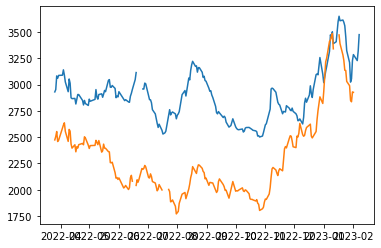

In [46]:
plt.plot(data)

In [3]:
import yfinance as yf

In [63]:
symbol1 = "TSLA"
symbol2 = "AAPL"
df1 = yf.download(symbol1)
for i in df1.columns:
    df1 = df1.rename(columns={f'{i}': f'{symbol1} {i}'})
df2 = yf.download(symbol2)
for i in df2.columns:
    df2 = df2.rename(columns={f'{i}': f'{symbol2} {i}'})
df = pd.concat([df1,df2],axis=1)
df.columns = pd.MultiIndex.from_tuples([(x.split(" ")[1], x.split(" ")[0]) for x in df.columns])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [64]:
df

,Open,High,Low,Close,Adj,Volume,Open,High,Low,Close,Adj,Volume
,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,,,,,,,
1980-12-12,NaN,NaN,NaN,NaN,NaN,NaN,0.128348,0.128906,0.128348,0.128348,0.099722,469033600
1980-12-15,NaN,NaN,NaN,NaN,NaN,NaN,0.122210,0.122210,0.121652,0.121652,0.094519,175884800
1980-12-16,NaN,NaN,NaN,NaN,NaN,NaN,0.113281,0.113281,0.112723,0.112723,0.087581,105728000
1980-12-17,NaN,NaN,NaN,NaN,NaN,NaN,0.115513,0.116071,0.115513,0.115513,0.089749,86441600
1980-12-18,NaN,NaN,NaN,NaN,NaN,NaN,0.118862,0.119420,0.118862,0.118862,0.092351,73449600
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-13,194.419998,196.300003,187.610001,194.639999,194.639999,172475500.0,150.949997,154.259995,150.919998,153.850006,153.850006,62199000
2023-02-14,191.940002,209.820007,189.440002,209.250000,209.250000,216455700.0,152.119995,153.770004,150.860001,153.199997,153.199997,61707600


In [69]:
df3 = yf.download([symbol1,symbol2])
#df3.drop(["Adj Close"], axis=1, inplace=True) 
df3

[*********************100%***********************]  2 of 2 completed


Adj Close                   Close                    High  \
                  AAPL        TSLA        AAPL        TSLA        AAPL   
Date                                                                     
1980-12-12    0.099722         NaN    0.128348         NaN    0.128906   
1980-12-15    0.094519         NaN    0.121652         NaN    0.122210   
1980-12-16    0.087582         NaN    0.112723         NaN    0.113281   
1980-12-17    0.089749         NaN    0.115513         NaN    0.116071   
1980-12-18    0.092351         NaN    0.118862         NaN    0.119420   
...                ...         ...         ...         ...         ...   
2023-02-13  153.850006  194.639999  153.850006  194.639999  154.259995   
2023-02-14  153.199997  209.250000  153.199997  209.250000  153.770004   
2023-02-15  155.330002  214.240005  155.330002  214.240005  155.500000   
2023-02-16  153.710007  202.039993  153.710007  202.039993  156.330002   
2023-02-17  152.550003  208.309998  152.550003  208.309998  153.000000   

                               Low                    Open              \
                  TSLA        AAPL        TSLA        AAPL        TSLA   
Date                                                                     
1980-12-12         NaN    0.128348         NaN    0.128348         NaN   
1980-12-15         NaN    0.121652         NaN    0.122210         NaN   
1980-12-16         NaN    0.112723         NaN    0.113281         NaN   
1980-12-17         NaN    0.115513         NaN    0.115513         NaN   
1980-12-18         NaN    0.118862         NaN    0.118862         NaN   
...                ...         ...         ...         ...         ...   
2023-02-13  196.300003  150.919998  187.610001  150.949997  194.419998   
2023-02-14  209.820007  150.860001  189.440002  152.119995  191.940002   
2023-02-15  214.660004  152.880005  206.110001  153.110001  211.759995   
2023-02-16  217.649994  153.350006  201.839996  153.509995  210.779999   
2023-02-17  208.440002  150.850006  197.500000  152.350006  199.990005   

               Volume               
                 AAPL         TSLA  
Date                                
1980-12-12  469033600          NaN  
1980-12-15  175884800          NaN  
1980-12-16  105728000          NaN  
1980-12-17   86441600          NaN  
1980-12-18   73449600          NaN  
...               ...          ...  
2023-02-13   62199000  172475500.0  
2023-02-14   61707600  216455700.0  
2023-02-15   65669300  182108600.0  
2023-02-16   68167900  229586500.0  
2023-02-17   59095900  213080200.0  

[10636 rows x 12 columns]

In [70]:
df3.drop(["Adj Close"], axis=1, inplace=True)
df3

Close                    High                     Low  \
                  AAPL        TSLA        AAPL        TSLA        AAPL   
Date                                                                     
1980-12-12    0.128348         NaN    0.128906         NaN    0.128348   
1980-12-15    0.121652         NaN    0.122210         NaN    0.121652   
1980-12-16    0.112723         NaN    0.113281         NaN    0.112723   
1980-12-17    0.115513         NaN    0.116071         NaN    0.115513   
1980-12-18    0.118862         NaN    0.119420         NaN    0.118862   
...                ...         ...         ...         ...         ...   
2023-02-13  153.850006  194.639999  154.259995  196.300003  150.919998   
2023-02-14  153.199997  209.250000  153.770004  209.820007  150.860001   
2023-02-15  155.330002  214.240005  155.500000  214.660004  152.880005   
2023-02-16  153.710007  202.039993  156.330002  217.649994  153.350006   
2023-02-17  152.550003  208.309998  153.000000  208.440002  150.850006   

                              Open                 Volume               
                  TSLA        AAPL        TSLA       AAPL         TSLA  
Date                                                                    
1980-12-12         NaN    0.128348         NaN  469033600          NaN  
1980-12-15         NaN    0.122210         NaN  175884800          NaN  
1980-12-16         NaN    0.113281         NaN  105728000          NaN  
1980-12-17         NaN    0.115513         NaN   86441600          NaN  
1980-12-18         NaN    0.118862         NaN   73449600          NaN  
...                ...         ...         ...        ...          ...  
2023-02-13  187.610001  150.949997  194.419998   62199000  172475500.0  
2023-02-14  189.440002  152.119995  191.940002   61707600  216455700.0  
2023-02-15  206.110001  153.110001  211.759995   65669300  182108600.0  
2023-02-16  201.839996  153.509995  210.779999   68167900  229586500.0  
2023-02-17  197.500000  152.350006  199.990005   59095900  213080200.0  

[10636 rows x 10 columns]